In [28]:
library(NELSI)

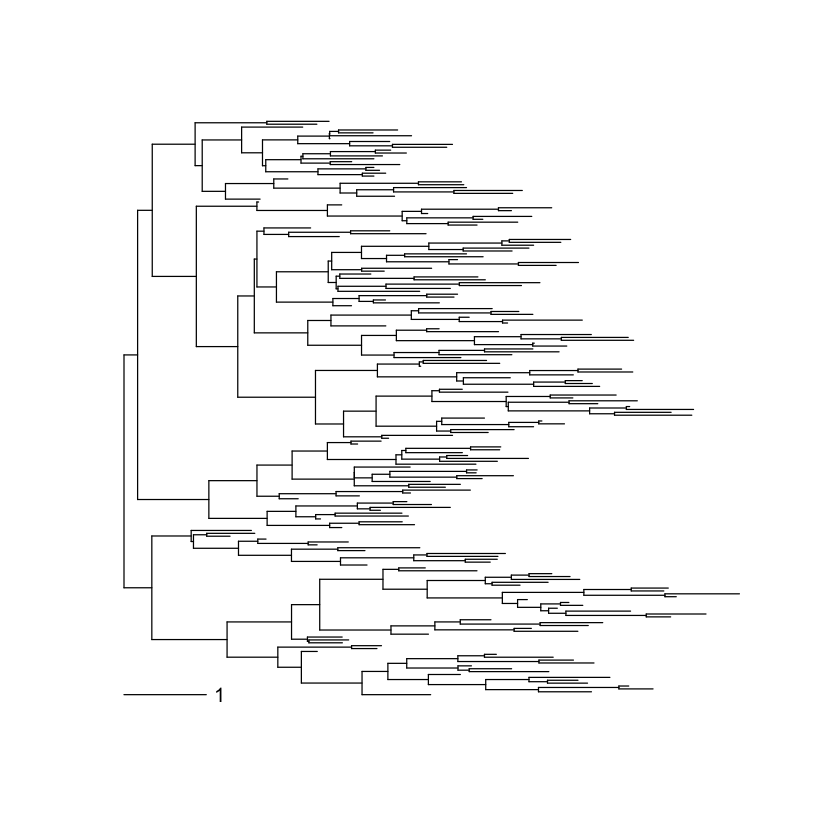

In [56]:
set.seed(123)
tr <- rtree(200)
plot(tr, show.tip.label = F)
#nodelabels(cex = 0.5)
#tiplabels(cex = 0.5)
#edgelabels(round(tr$edge.length, 2), cex  = 0.5)
add.scale.bar()

In [57]:
# states at the root. nus[1] is the weight for the variance due to time, nus[2] is the weight for the 
# variance due to the value of the previous state

root_state <- 0.1
nus <- c(0.01, 5)


In [58]:
node_ages <- allnode.times(tr)
node_ages <- abs(node_ages - max(node_ages))
root_node <- unique(tr$edge[!(tr$edge[, 1] %in% tr$edge[, 2]), 1])
node_states <- cbind(as.numeric(names(node_ages)), rep(NA, length(node_ages)))
node_states[node_states[, 1] == root_node, 2] <- root_state
all_tips <- 1:length(tr$tip.label)

tips_traces <- list()
for(tip in all_tips){
    tip_temp <- get.ancestor.nodes.branches(tr, tip)
    nodes_i <- rev(tip_temp$ancestor.nodes)
    tips_traces[[tip]] <- list()
    tips_traces[[tip]][[1]] <- vector()#differences in node ages
    tips_traces[[tip]][[2]] <- vector()#IS number
    tips_traces[[tip]][[3]] <- vector()#differences in IS number
    for(i in 2:length(nodes_i)){
        if(is.na(node_states[node_states[, 1] == nodes_i[i], 2])){
            diff_times <- abs(node_ages[names(node_ages) == nodes_i[i]] - node_ages[names(node_ages) == nodes_i[i-1]])
            nu_time <- diff_times * nus[1]
            nu_state <- abs(node_states[node_states[, 1] == nodes_i[i-1], 2]) * nus[2]
            nu_total <- nu_time + nu_state
            new_state <- node_states[node_states[, 1] == nodes_i[i-1], 2] + (rnorm(1, 0, nu_total))        
            node_states[node_states[, 1] == nodes_i[i], 2] <- new_state
            tips_traces[[tip]][[1]] <- c(tips_traces[[tip]][[1]], diff_times)
            tips_traces[[tip]][[2]] <- c(tips_traces[[tip]][[2]], new_state)
            tips_traces[[tip]][[3]] <- c(tips_traces[[tip]][[3]], 
                                         new_state - node_states[node_states[, 1] == nodes_i[i-1], 2])
        }
        nodes_in_path <- node_states[, 1] %in% nodes_i
        tips_traces[[tip]][[4]] <- cbind(node_ages[nodes_in_path], node_states[nodes_in_path, 2])

    }
}

In [59]:
write.table(node_states, file = 'tree_states_alpha.csv', row.names = F, sep= ',')
write.tree(tr, file = 'tree_states_alpha.tree')

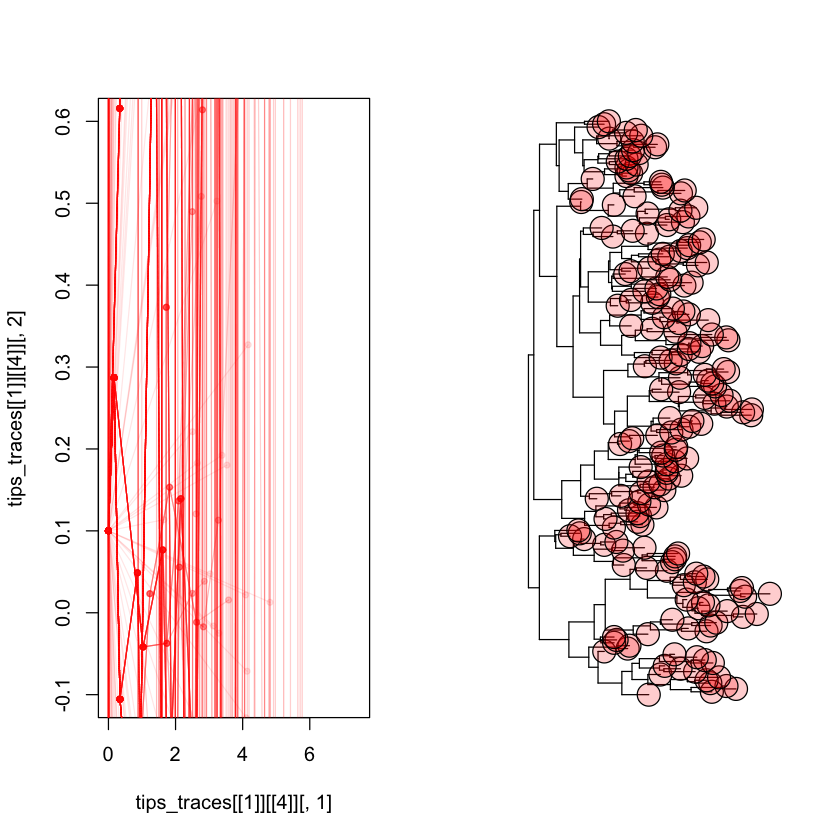

In [60]:
par(mfrow = c(1, 2))
col <- rgb(1, 0, 0, 0.1)
plot(tips_traces[[1]][[4]][, 1], tips_traces[[1]][[4]][, 2], type = 'b', ylim = c(-0.1, .6), pch = 20,
    xlim = c(0, max(node_ages)), col = col)
for(f in tips_traces[-1]){
    points(f[[4]][, 1], f[[4]][, 2], col = col, pch = 20)
    lines(f[[4]][, 1], f[[4]][, 2], col = col)
}

plot(tr, show.tip.label = F)
tiplabels(frame = 'circle', bg =rgb(1, 0, 0, 0.2), text = rep('', length(tr$tip.label)))

In [61]:
c1 <- vector()
c2 <- vector()
# cor between dtime and dIS
# cor between IS and dIS
for(i in 1:length(tips_traces)){
    if(length(tips_traces[[i]][[1]]) > 1){
        c1 <- c(c1, cor(tips_traces[[i]][[1]], tips_traces[[i]][[3]]))
        c2 <- c(c2, cor(tips_traces[[i]][[2]], tips_traces[[i]][[3]]))
    }
}

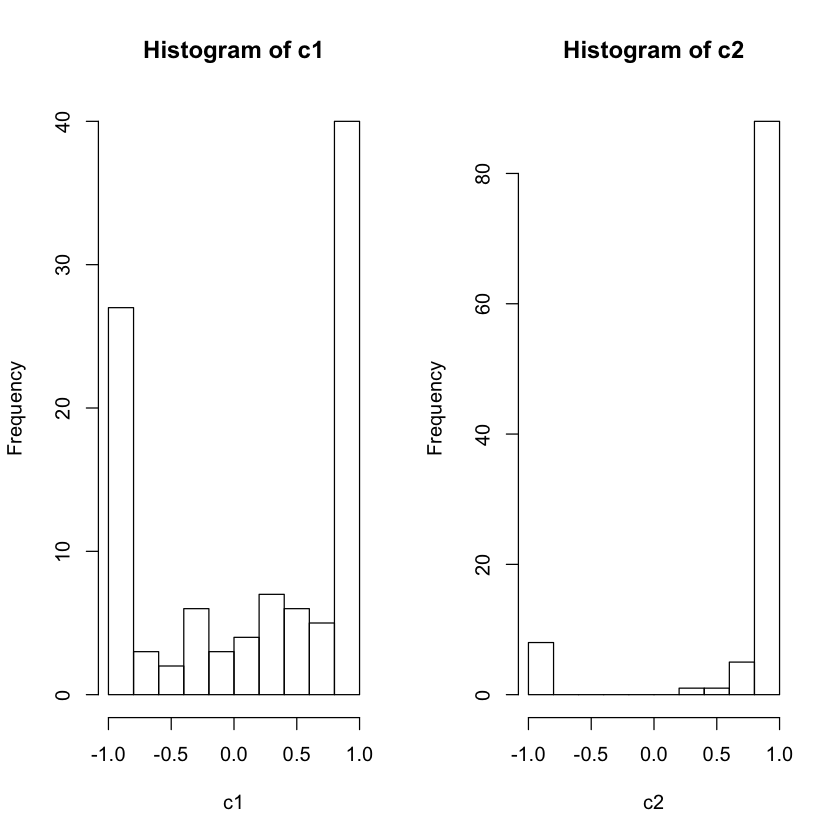

In [62]:
par(mfrow = c(1, 2))
hist(c1)
hist(c2)